In [4]:
import pymc as pm
import terrain.pnw as terrain
import numpy as np 
import arviz as az
import scipy
import matplotlib.pyplot as plt
import pytensor.tensor as at

TER = terrain.pnw_2d

h0 =8
# velocity is non dimensionalized in units/time
v0 = 4
heading = np.deg2rad(40 )
vV = v0 * np.array( [ np.cos( heading) , np.sin(heading)])
# time will be non-dim from 0-1
t0 = 0.0 
tf = 1.0
# initial position
x0 = [-122.253748,47.588818]
#
# rvs
sigma = 0.005
alt_error = scipy.stats.norm( loc=0, scale=sigma ) 
# generate simulated measurements
t_true=  np.linspace( start=t0 ,stop=tf , num=10000)
t_true.shape = ( len(t_true),1)
t_measured = t_true #+ time_error.rvs( size= len(t_true) ) 
x_measured = x0 + vV * t_measured
#s = sim.Map_1D( "1dim.csv")
a_true =  h0 - terrain.pnw_2d.sample( long=x_measured[:,0] , lat=x_measured[:,1] )
a_measured = a_true + alt_error.rvs( size=a_true.shape)


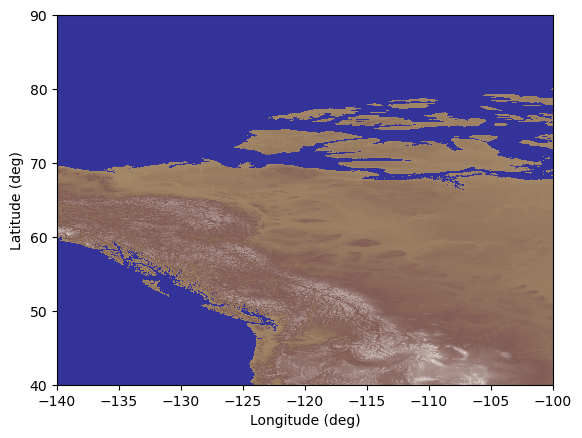

In [3]:
terrain.pnw_2d.show_map(1)
plt.show()

Text(0, 0.5, 'Radar Altimeter')

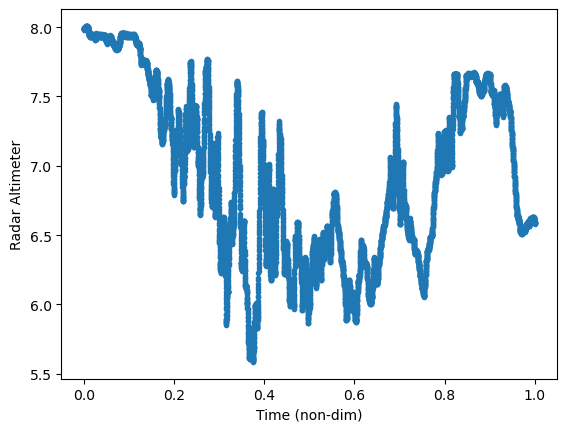

In [5]:
plt.figure(2)
plt.plot( t_measured , a_measured , marker="." )
plt.xlabel("Time (non-dim)")
plt.ylabel("Radar Altimeter")


In [5]:
import pymc.math



xPixels = TER.shape( )[1]
yPixels = TER.shape( )[0]

with pm.Model() as uPriors:
    # associate data with model (this makes prediction easier)
    H_data = pm.Data("Hm", a_measured.flatten(), mutable=False)
    T_data = pm.Data("Tm", t_measured.flatten(), mutable=True )
    # priors - uniform giving equal weight to all possible locations and velocities in range
    X0 = pm.Uniform("x0",lower=-127.5, upper=-126)  
    Y0 =  pm.Uniform("y0" , lower=49.5 , upper=50.2)  
    H0 = 8 #pm.Uniform("h0", lower=7.8, upper=8.2) 
    V0 =  10#pm.Uniform("v0", lower=9.8, upper=10.3)
    theta = pm.Uniform("theta", lower=39, upper=42)
    sigmaM =  pm.Gamma( "Sigma", alpha=1, beta=1)
    sigmaKm = sigmaM / 1000.0 
    # X position through the terrain 

    X = X0 + (V0 * pm.math.cos( np.pi * theta / 180.0)* T_data)
    Y = Y0 + (V0 * pm.math.sin( np.pi * theta / 180.0 )* T_data )

    T = terrain.terrain_alt_2d( X, Y )

    #
    A = pm.Normal( "Alt", mu = H0 - T, sigma=sigmaKm, observed=H_data)
    # start sampling
    trace = pm.sample(5000, chains=4, cores=12)

Multiprocess sampling (4 chains in 12 jobs)
CompoundStep
>CompoundStep
>>Slice: [x0]
>>Slice: [y0]
>>Slice: [theta]
>NUTS: [Sigma]


In [ ]:
az.summary( trace )

In [ ]:
az.plot_posterior( trace )